In [1]:
import os
import sys
import yaml
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, parent_dir)
os.chdir(parent_dir)
from src.utils import *
from src.imputation import MICE
from src.t_star import TStar 
from src.preprocessingPipeline import PreprocessingPipeline
from src.metrics import Metrics
from src.subpopulations import SubpopulationCreator
from src.coxphm import CoxProportionalHazardsModel
from src.subpopulations import SubpopulationCreator
from src.monte_carlo import Monte_Carlo_Cross_Validation
from lifelines import CoxPHFitter
from patsy import dmatrix
import patsy.splines 
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
with open('paths.yaml', 'r') as file:
    paths = yaml.safe_load(file)

path_prediction = paths['PATH_PREDICTION']
path_data = paths['PATH_IMPUTED']

t_b:  2000-01-01 00:00:00
t_final_training_period:  2019-12-31 00:00:00
t_final_event_period:  2019-12-31 00:00:00
t_final_prediction_period:  2020-12-31 00:00:00
t_final_prediction_tx_period:  2020-12-31 00:00:00
(24138, 61)
(24138, 62) after set_time
2000-01-01 00:00:00
0       2000-01-01
1       2000-01-01
2       2000-01-01
3       2000-01-01
4       2000-01-01
           ...    
24133   2019-01-01
24134   2019-01-01
24135   2019-01-01
24136   2019-01-01
24137   2019-01-01
Name: TX_DATE, Length: 24138, dtype: datetime64[ns]
(24138, 62) after filtering by base year
(24138, 62) after filtering by testing window
(24138, 62) after filtering by testing window
skipping preprocessing in EUROTRANSPLANT
skipping preprocessing in EUROTRANSPLANT
Iteration 1: norm_delta = 4.02e-01, step_size = 0.9500, log_lik = -37329.32155, newton_decrement = 2.92e+02, seconds_since_start = 0.2
Iteration 2: norm_delta = 6.54e-02, step_size = 0.9500, log_lik = -37029.41138, newton_decrement = 5.98e+00, seconds

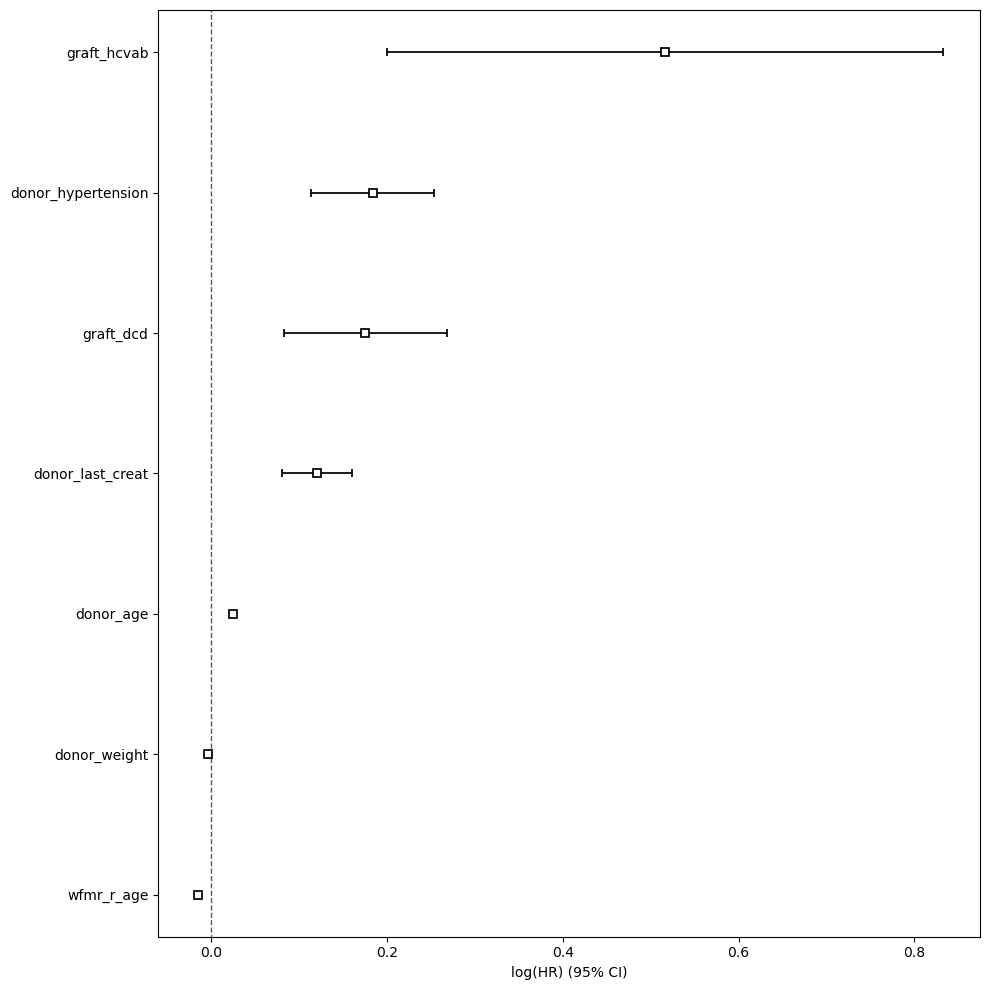

In [3]:
date_for_prediction = int(365.25*5)

t_star = TStar(t_star_date="31-12-2019", txpt=20, 
            ept=20, txpp=1, epp=1, 
            load=False, indexes_from_ID=None, dataset='EUROTRANSPLANT')

columns = ['time_to_graft_failure', 'graft_failure','time_to_dcgl','dcgl',
            'diag_group_at_exit', 'donor_age', 'd_height', 'donor_last_creat',
            'graft_dcd', 'donor_hypertension', 'donor_diabetes', 'donor_weight',
            'death_cause_group', 'graft_hcvab', 'wfmr_r_age', 'time_on_dial',
            'd_urine_protein', 'mmb_hla_a', 'mmb_hla_b', 'mmb_hla_c', 'mmb_hla_dr',
            'mmb_hla_dqb', 'mms_hla_b', 'mms_hla_a', 'mms_hla_c', 'mms_hla_dqb',
            'mms_hla_dr', 'year_txp', 'max_pra', 'vpra', 'er_mmlod_i_abv',
            'er_mmlod_i_oth', 'er_mmlod_drb1345_abv', 'er_mmlod_drb1345_oth',
            'er_mmlod_dq_abv', 'er_mmlod_dq_oth', 'er_mmlod_per_locus_hla_a',
            'er_mmlod_per_locus_hla_b', 'er_mmlod_per_locus_hla_c',
            'er_mmlod_per_locus_hla_dr', 'er_mmlod_per_locus_hla_drb345',
            'er_mmlod_per_locus_hla_dqb', 'er_mmlod_per_locus_hla_dqa',
            'emma_sa_aa_total', 'emma_sa_aa_a', 'emma_sa_aa_b', 'emma_sa_aa_c',
            'emma_sa_aa_dr', 'emma_sa_aa_dqa1', 'emma_sa_aa_dqb1']
 
predictors = ['donor_age', 'wfmr_r_age', 'donor_weight', 
              'donor_hypertension', 'donor_last_creat', 
              'graft_dcd', 'graft_hcvab']

t_star.set_predictors(predictors, columns)

t_star.get_data(model_type='cphm', time_variable_name='time_to_dcgl', status_variable_name='dcgl')

pipeline = PreprocessingPipeline(binarization=False, range_check=False, 
                            time_in_dialysis_from_date=False)

df_train, _  = pipeline.run(t_star)  

predictors_to_remove = []
df_train = pipeline.delete_predictor_from_date_set(df_train, predictors=predictors_to_remove)
t_star = pipeline.delete_predictor_from_t_star(t_star, predictors=predictors_to_remove)

df_train.dropna(subset = t_star.predictors, inplace=True)

# Fit Cox Proportional Hazards model
model = CoxPHFitter(penalizer=0.0, l1_ratio=0)
model.fit(df_train[['time_to_dcgl', 'dcgl'] + predictors], 
          duration_col='time_to_dcgl', event_col='dcgl', show_progress=True)

        
plt.figure(figsize=(10, 10))
model.plot()
plt.tight_layout()
plt.savefig('death_censored.png')

In [4]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 22992 total observations, 19027 right-censored observations>
             duration col = 'time_to_dcgl'
                event col = 'dcgl'
      baseline estimation = breslow
   number of observations = 22992
number of events observed = 3965
   partial log-likelihood = -37023.33
         time fit was run = 2025-08-12 14:09:32 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
donor_age           0.02      1.03      0.00            0.02            0.03                1.02                1.03
wfmr_r_age         -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
donor_weight       -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
donor_hypertension  0.18      1.20      0.04            0.11            0.25                1.12                1.29
donor_last_creat    0.12      1.13      0.02            0.08            0.16                1.08                1.17
graft_dcd           0.18      1.19      0.05            0.08            0.27                1.09                1.31
graft_hcvab         0.52      1.68      0.16            0.20            0.83                1.22                2.30

                    cmp to      z      p  -log2(p)
covariate                                         
donor_age             0.00  18.71 <0.005    256.98
wfmr_r_age            0.00 -11.23 <0.005     94.78
donor_weight          0.00  -3.25 <0.005      9.77
donor_hypertension    0.00   5.13 <0.005     21.73
donor_last_creat      0.00   5.98 <0.005     28.74
graft_dcd             0.00   3.71 <0.005     12.23
graft_hcvab           0.00   3.20 <0.005      9.52
---
Concordance = 0.61
Partial AIC = 74060.65
log-likelihood ratio test = 611.99 on 7 df
-log2(p) of ll-ratio test = 422.54

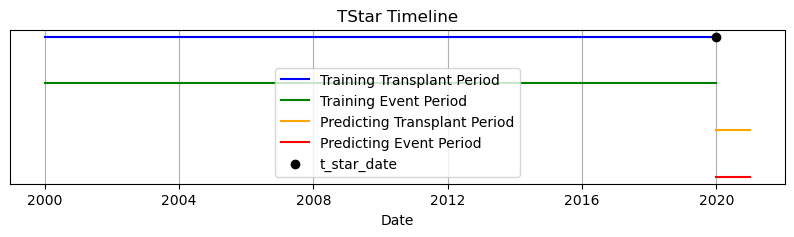

In [5]:
t_star.visualize_t_star()  